# A Tutorial for how to use Rapids

**IMPORTANT:** This notebook uses a conda environment that I created to support this tutorial.

I'm using Python 3.6 in this environment.  After creating the environment, run the following commands.

- `conda install matplotlib`
- `conda install scikit-learn`
- `conda install -c rapidsai -c nvidia -c conda-forge -c defaults rapids=0.14 python=3.6`

Note: The last command came from this page: https://rapids.ai/start.html

In [1]:
!python --version

Python 3.6.11


KDnuggets site link: https://www.kdnuggets.com/2019/07/accelerate-data-science-on-gpu.html

We’ll start by getting all of our imports setup. Libraries for loading data, visualising data, and applying ML models.

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles

The make_circles functions will automatically create a complex distribution of data resembling two circles that we’ll apply DBSCAN on.

Let’s start by creating our dataset of 100,000 points and visualising it in a plot:

In [6]:
get_color = lambda c: 'blue' if c==1 else 'red'

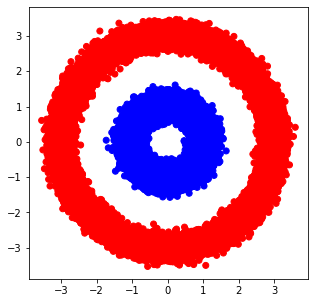

In [7]:
X, y = make_circles(n_samples=int(1e5), factor=.35, noise=.05)
X[:, 0] = 3*X[:, 0]
X[:, 1] = 3*X[:, 1]

get_color = lambda c: 'blue' if c==1 else 'red'
colors = np.array([get_color(c) for c in y])

plt.figure(figsize=(5, 5))
plt.scatter(x=X[:, 0], y=X[:, 1], c=colors)
plt.show()

In [8]:
X.shape

(100000, 2)

In [9]:
y.shape

(100000,)

### DBSCAN on CPU

Running DBSCAN on CPU is easy with Scikit-Learn. We’ll import our algorithm and setup some parameters.

In [10]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.6, min_samples=2)

We can now apply DBSCAN on our circle data with a single function call from Scikit-Learn. Putting a `%%time` before our function tells Jupyter Notebook to measure its run time.

In [11]:
%%time
y_db = db.fit_predict(X)

CPU times: user 5.27 s, sys: 1.25 s, total: 6.52 s
Wall time: 6.52 s


In [12]:
colors_ydb = np.array([get_color(c) for c in y_db])

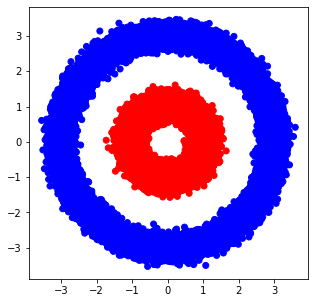

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(x=X[:, 0], y=X[:, 1], c=colors_ydb)
plt.show()

### DBSCAN with Rapids on GPU

Now let’s make things faster with Rapids!

First, we’ll convert our data to a pandas.DataFrame and use that to create a cudf.DataFrame. Pandas dataframes are converted seamlessly to cuDF dataframes without any change in the data format.

In [14]:
import pandas as pd
import cudf

X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

In [15]:
X_gpu.head(10)

,fea0,fea1
0,0.664314,0.659762
1,0.820625,-0.406585
2,0.478508,1.029942
3,0.995977,0.561033
4,-1.183088,-0.205848
5,0.371170,-0.597696
6,2.019330,-2.426140
7,-1.421724,-0.339647
8,-0.431360,-0.838896
9,-0.257901,-1.038497


We’ll then import and initialise a special version of DBSCAN from cuML, one that is GPU accelerated. The function format of the cuML version of DBSCAN is the exact same as that of Scikit-Learn — same parameters, same style, same functions.

In [16]:
from cuml import DBSCAN as cumlDBSCAN

db_gpu = cumlDBSCAN(eps=0.6, min_samples=2, output_type='numpy')

Finally, we can run our prediction function for the GPU DBSCAN while measuring the run time.

In [17]:
%%time
y_db_gpu = db_gpu.fit_predict(X_gpu)

CPU times: user 2.59 s, sys: 9.83 ms, total: 2.6 s
Wall time: 2.6 s


In [18]:
type(y_db_gpu)

numpy.ndarray

In [19]:
y_db_gpu.shape

(100000,)

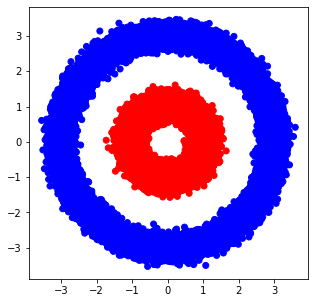

In [20]:
colors_y_db_gpu = np.array([get_color(c) for c in y_db_gpu])

plt.figure(figsize=(5, 5))
plt.scatter(x=X[:, 0], y=X[:, 1], c=colors_y_db_gpu)
plt.show()

### Getting super speed with Rapids GPU

The amount of speedup we get from Rapids depends on how much data we are processing. A good rule of thumb is that larger datasets will benefit from GPU acceleration. There is some overhead time associated with transferring data between the CPU and GPU — that overhead time becomes more “worth it” with larger datasets.

We can illustrate this with a simple example.

We’re going to create a Numpy array of random numbers and apply DBSCAN on it. We’ll compare the speed of our regular CPU DBSCAN and the GPU version from cuML, while increasing and decreasing the number of data points to see how it effects our run time.

The code below illustrates this test:

In [21]:
n_rows, n_cols = 10000, 100
X = np.random.rand(n_rows, n_cols)
print(X.shape)

X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

db = DBSCAN(eps=3, min_samples=2)
db_gpu = cumlDBSCAN(eps=3, min_samples=2)

(10000, 100)


In [22]:
%%time
y_db = db.fit_predict(X)

CPU times: user 18.5 s, sys: 0 ns, total: 18.5 s
Wall time: 18.5 s


In [23]:
%%time
y_db_gpu = db_gpu.fit_predict(X_gpu)

CPU times: user 177 ms, sys: 19.6 ms, total: 197 ms
Wall time: 196 ms
